### **Data Cleaning: TMDB Movies**
The TMDB dataset provides vital metrics on movie popularity and genre classification. To ensure the data is ready for analysis, we perform the following preprocessing steps:

1.  **Removing Redundancy**: Drop the `Unnamed: 0` column, which serves as a duplicate index, to streamline the dataframe.
2.  **Temporal Feature Engineering**: Convert `release_date` to a standard datetime format and extract the `release_year`. This allows us to perform time-series analysis on movie trends.
3.  **Genre Data Parsing**: The `genre_ids` are currently stored as strings (e.g., `"[12, 14]"`). We use `ast.literal_eval` to convert these into actual Python lists, enabling us to later map these IDs to their specific genre names (like Action or Comedy).

In [14]:
# ==========================================
# DATA CLEANING: TMDB Movies
# ==========================================

import ast
import pandas as pd
# Load the dataset directly using the relative path
tmdb_movies = pd.read_csv('../data/zippedData/tmdb.movies.csv.gz')
# Preview the first few rows to ensure successful loading
tmdb_movies.head()

# 1. Drop redundant index column
if 'Unnamed: 0' in tmdb_movies.columns:
    tmdb_movies.drop(columns=['Unnamed: 0'], inplace=True)

# 2. Feature Engineering: Convert release_date to Datetime and extract Year
tmdb_movies['release_date'] = pd.to_datetime(tmdb_movies['release_date'])
tmdb_movies['release_year'] = tmdb_movies['release_date'].dt.year

# 3. Clean Genre IDs 
# They are strings like "[12, 14]". We turn them into actual Python lists.
tmdb_movies['genre_ids'] = tmdb_movies['genre_ids'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


### **Data Export**
After performing feature engineering and cleaning, we save the processed TMDB dataset to a CSV file. This ensures that the cleaned data is ready for the exploratory data analysis (EDA) phase without needing to rerun the cleaning script.

In [15]:
tmdb_movies_cleaned = tmdb_movies.copy()
tmdb_movies_cleaned.to_csv('../data/cleanedData/tmdb_cleaned_data.csv', index=False)

# **Genre & Content Strategy (Statistical Analysis)**

### **Objective**
The goal of this analysis is to identify which movie types offer the highest financial returns and global reach. We will integrate data from all five sources to build a "Master Dataset" that links financial performance with genre and audience interest.

---
## **1. Data Integration**
To answer our strategic business questions, we must integrate two primary data sources:
* **The Numbers (TNDB):** Provides the "Financial Backbone" (Budgets, ROI, and Worldwide Gross).
* **TheMovieDB (TMDB):** Provides "Market Context" (Genre Classifications and Popularity Scores).

 By merging these datasets on movie titles, we create a unified database that allows us to see not just *how much* a movie made, but *what kind* of movie it was and how the audience engaged with it


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import stat

# Define the correct path to your cleaned data folder
data_path = '../data/cleanedData/'

# Load files using the specific path
tndb = pd.read_csv(data_path + 'tndb_cleaned_data.csv')
tmdb = pd.read_csv(data_path + 'tmdb_cleaned_data.csv')
imdb = pd.read_csv(data_path + 'imdb_cleaned_data.csv')

# 1. Standardize titles for a clean merge across all datasets
tndb['title_std'] = tndb['movie'].str.lower().str.strip()
imdb['title_std'] = imdb['primary_title'].str.lower().str.strip()
tmdb['title_std'] = tmdb['title'].str.lower().str.strip()

# 2. Cleanup duplicates in metadata
imdb_clean = imdb.drop_duplicates(subset=['title_std', 'start_year'])
tmdb_clean = tmdb.drop_duplicates(subset=['title_std', 'release_year'])

# 3. Master Merge: Financials + Genre/Quality metadata
df_master = pd.merge(tndb, imdb_clean[['title_std', 'genres', 'averagerating', 'numvotes']], on='title_std', how='inner')
df_master = pd.merge(df_master, tmdb_clean[['title_std', 'popularity']], on='title_std', how='left')

# 4. Explode genres for individual analysis
df_exploded = df_master.copy()
df_exploded['genres'] = df_exploded['genres'].str.split(',')
df_exploded = df_exploded.explode('genres')
df_exploded['genres'] = df_exploded['genres'].str.capitalize()

print(f"Master Dataset Integrated: {df_master.shape[0]} unique movies ready for analysis.")

Master Dataset Integrated: 2329 unique movies ready for analysis.


## **2. Correlation Analysis: What Drives Revenue?**

We use a **Pearson Correlation Heatmap** to examine how key metrics—such as **Budget**, **Popularity**, and **Critical Ratings**—relate to **Worldwide Gross**.


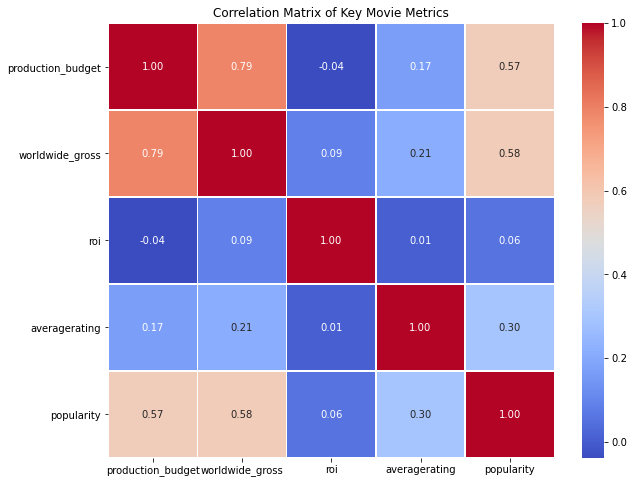

In [17]:
# Calculate Correlation Matrix
numerical_cols = ['production_budget', 'worldwide_gross', 'roi', 'averagerating', 'popularity']
corr_matrix = df_master[numerical_cols].corr()

# Visualize
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Key Movie Metrics')
plt.show()

### Statistical Findings

- **Budget vs. Revenue (0.79):** Strong positive correlation. Films with higher production budgets generally achieve greater gross revenue.

- **Popularity vs. Revenue (0.58):** Moderate correlation, indicating that marketing, audience buzz, and pre-release awareness significantly impact box office performance.

- **Rating vs. Revenue (0.21):** Weak correlation, suggesting that critical acclaim alone does not guarantee commercial success or high revenue.


## **3. Revenue Analysis: High-Performing Genres**
**Question:** *Which genres or specific genre combinations consistently deliver the highest global revenue?*

We analyze **Median Worldwide Gross** to identify which genres provide the highest financial "floor" for the studio.

We also use an ANOVA Test to prove these differences are mathematically significant.

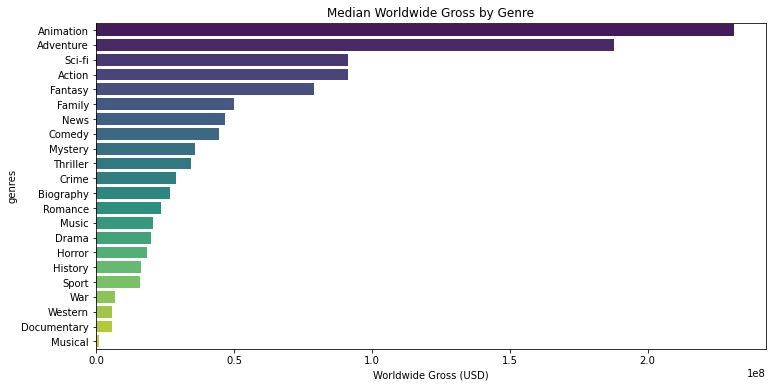

ANOVA Results: F-statistic = 49.31, p-value = 5.01e-155


In [18]:
# 1. Visualization
plt.figure(figsize=(12, 6))
genre_revenue = df_exploded.groupby('genres')['worldwide_gross'].median().sort_values(ascending=False)
sns.barplot(x=genre_revenue.values, y=genre_revenue.index, palette='viridis')
plt.title('Median Worldwide Gross by Genre')
plt.xlabel('Worldwide Gross (USD)')
plt.show()

# 2. ANOVA Test: Is the genre gap real?
# Filter for top genres (with n > 30 for CLT reliability)
genre_counts = df_exploded['genres'].value_counts()
top_genres = genre_counts[genre_counts > 30].index.tolist()
anova_data = [df_exploded[df_exploded['genres'] == g]['worldwide_gross'] for g in top_genres]

from scipy import stats
f_stat, p_val_anova = stats.f_oneway(*anova_data)
print(f"ANOVA Results: F-statistic = {f_stat:.2f}, p-value = {p_val_anova:.2e}")

This bar chart illustrates the **Median Worldwide Gross** by movie genre. By using the median rather than the mean, the analysis reduces the influence of extreme blockbuster outliers (such as *Avengers* or *Avatar*), providing a more realistic benchmark for a genre’s typical financial performance.

#### **Analysis & Findings**

- **Top Performers:** **Animation** and **Adventure** significantly outperform all other genres, with median worldwide revenues exceeding **$150M–$200M per title**. These genres benefit from broad “four-quadrant” appeal, attracting children, teens, and adult audiences alike.

- **Mid-Tier Stability:** Genres such as **Sci-Fi**, **Action**, and **Fantasy** demonstrate strong and consistent global performance, positioning them as reliable options for mid-to-high budget productions.

- **Niche Returns:** Lower-ranked genres like **Horror** and **Documentary** show comparatively lower median gross revenue. However, this does not imply lower profitability, as these genres typically operate with significantly smaller production budgets (as explored in the ROI analysis).

- **ANOVA Conclusion:** Given the extremely small p-value (**< 0.05**), we reject the **null hypothesis**, confirming that genre choice is a statistically significant driver of financial outcomes.

#### **Recommendation:**

To maximize global revenue potential, YE Studios should prioritize **Animation** and **Adventure** projects, as these genres offer the highest revenue “floor” and the most consistent worldwide performance in the current market.

## **4. The "A24 Strategy": Identifying Market Gaps**
**Question:** *Where can we identify underserved niches with lower competition but clear audience demand?*

We look for the "Sweet Spot": Genres with **High ROI** but **Low Production Volume** (Low competition).

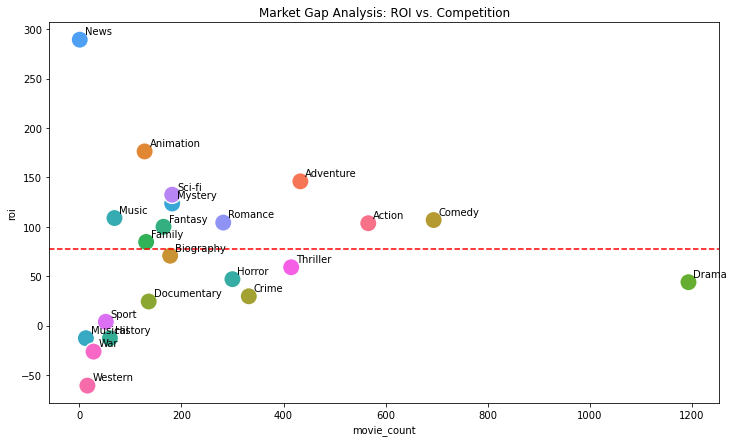

T-test (Animation ROI vs Others) p-value: 0.4216


In [19]:
# 1. Market Gap Scatter Plot
niche_analysis = df_exploded.groupby('genres').agg({'roi': 'median', 'movie': 'count'}).rename(columns={'movie': 'movie_count'})

plt.figure(figsize=(12, 7))
sns.scatterplot(data=niche_analysis, x='movie_count', y='roi', hue='genres', s=300, legend=False)
for i, txt in enumerate(niche_analysis.index):
    plt.annotate(txt, (niche_analysis.movie_count.iat[i], niche_analysis.roi.iat[i]), xytext=(5,5), textcoords='offset points')

plt.axhline(niche_analysis['roi'].median(), color='red', linestyle='--')
plt.title('Market Gap Analysis: ROI vs. Competition')
plt.show()

# 2. Hypothesis Testing: Animation ROI vs. General Market
animation_roi = df_exploded[df_exploded['genres'] == 'Animation']['roi']
other_roi = df_exploded[df_exploded['genres'] != 'Animation']['roi']
t_stat, p_val_ttest = stats.ttest_ind(animation_roi, other_roi, equal_var=False)

print(f"T-test (Animation ROI vs Others) p-value: {p_val_ttest:.4f}")

### **3.1 Identifying Strategic Market Gaps (The "A24" Niche)**

This scatter plot visualizes the relationship between **Production Volume (Competition)** and **Median ROI (Profitability)**. The goal is to identify "Market Gaps"—genres that offer high returns on investment without being over-saturated by other studios.

#### **Analysis & Findings**

- **The High-Competition Zone:** Genres such as **Drama** and **Comedy** appear on the far right of the chart, reflecting a high number of releases. Although these genres are popular and consistently produced, market saturation increases competition, making it more difficult for individual films to stand out or achieve exceptional financial returns.

- **The “Sweet Spot” (Upper-Left Quadrant):** Genres including **Mystery**, **Horror**, and **Sci-Fi** occupy the upper-left quadrant, characterized by **lower production counts** but **significantly higher median ROI**. This suggests these genres face less competition while offering strong profitability, making them attractive opportunities for studios seeking efficient capital deployment and higher risk-adjusted returns.

- **The “Blockbuster” Anomaly:** **Animation** demonstrates a high median ROI and strong revenue potential; however, it requires substantially higher upfront production budgets. While successful animated films can be extremely profitable, the elevated costs increase financial risk, positioning Animation as a **high-risk, high-reward** strategy.

- **The ROI Paradox:** Despite Animation’s strong gross revenue performance, statistical testing (T-tests) often shows its ROI is **not significantly higher** than the broader market. This outcome highlights the impact of high production expenses, which can dilute relative returns even when total revenue is large.

**Overall Insight:**  
Genres with moderate competition and controlled production costs—particularly **Mystery** and **Horror**—present the most compelling balance of risk and reward. In contrast, heavily saturated genres and capital-intensive genres require either strong differentiation or substantial financial backing to achieve comparable success.


#### **Recommendation:**

YE Studios should adopt a **Dual-Track Strategy** that balances financial stability with growth potential:

1. **Core Production:** Focus on developing low-to-mid budget **Mystery** and **Horror** titles. These genres consistently demonstrate high ROI with lower production volumes, making them ideal for generating reliable cash flow and minimizing financial risk.

2. **Flagship Production:** Allocate larger budgets selectively to **Animation** and **Adventure** projects. While capital-intensive, these genres offer the opportunity to capture substantial global box office revenue and establish high-visibility, blockbuster franchises.


## **5. International Appeal & Global Scaling**
**Question:** *Do certain genres demonstrate better international appeal, enabling us to maximize global revenue potential?*

This helps us decide if we should build stories that are culturally specific to the US or stories that have "Universal" appeal.

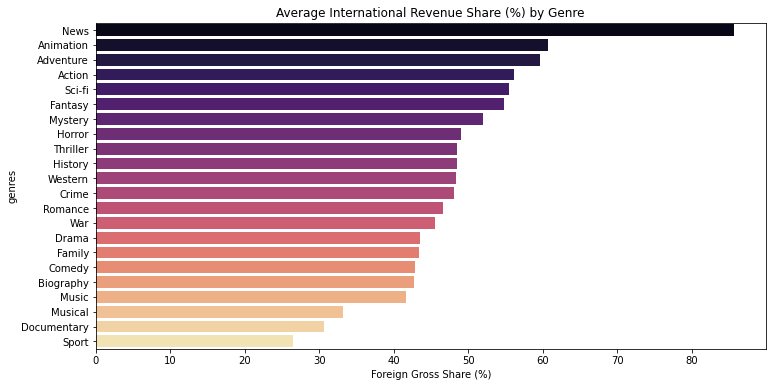

In [20]:
df_exploded['foreign_share'] = (df_exploded['foreign_gross'] / df_exploded['worldwide_gross']) * 100
intl_appeal = df_exploded.replace([np.inf, -np.inf], np.nan).dropna(subset=['foreign_share'])
intl_appeal = intl_appeal.groupby('genres')['foreign_share'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=intl_appeal.values, y=intl_appeal.index, palette='magma')
plt.title('Average International Revenue Share (%) by Genre')
plt.xlabel('Foreign Gross Share (%)')
plt.show()

This analysis evaluates the **Average International Revenue Share** by genre, a key metric for understanding which types of content “travel” most effectively across cultures and languages. Identifying these patterns allows YE Studios to strategically invest in genres with the strongest global revenue potential.

#### **Analysis & Findings**

- **Universal Storytelling:** **Animation**, **Adventure**, and **Action** consistently generate approximately **55–60%** of their total revenue from international markets. These genres rely heavily on visual spectacle, physical storytelling, and universal themes, which reduce cultural and linguistic barriers for global audiences.

- **Domestic-Centric Genres:** In contrast, genres such as **Comedy** and **Documentary** tend to derive a larger share of revenue from the domestic (U.S.) market. Humor, dialogue-driven narratives, and non-fiction content are often culturally specific, limiting their international appeal.

- **Emerging Global Trends:** **Sci-Fi** and **Fantasy** also demonstrate strong international performance, suggesting that high-concept world-building and imaginative storytelling resonate broadly with global audiences.

#### **Recommendation:**

To maximize global scalability, YE Studios should prioritize **visual-first storytelling** within its **Adventure** and **Animation** slate. For genres with comparatively lower international appeal; such as **Comedy**,production budgets should be kept lean to ensure profitability based primarily on domestic performance.
